# Stock Prediction Project

In [4]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

data = pd.read_csv("data.csv", parse_dates=["date"], index_col="date")
x = pd.DataFrame(data)
x.head(10)

,signal,spy_close_price
date,,
2012-01-03,3.107767,127.495
2012-01-04,3.107282,127.700
2012-01-05,3.099757,128.040
2012-01-06,3.134223,127.710
2012-01-09,3.135922,128.020
2012-01-10,3.143447,129.130
2012-01-11,3.127184,129.200
2012-01-12,3.139320,129.510
2012-01-13,3.174029,128.840


## CLEAN UP THE DATA

We clean the data by removing the outliers that exist in the data

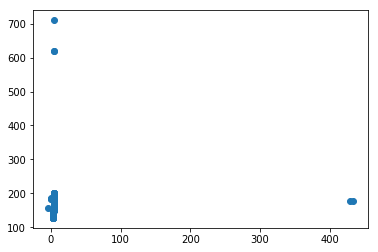

In [5]:
#claim: there's a correlation btw signal and close_price

#first step is to clean the data

plt.scatter(x['signal'], x['spy_close_price'])
plt.show()

In [6]:
linear_data = x
linear_data = linear_data[linear_data.loc[:,'spy_close_price'] < 300]
linear_data = linear_data[linear_data.loc[:,'signal'] < 100]
linear_data = linear_data[linear_data.loc[:,'signal'] > 2]

### We can now see that their is indeed a correlation between signal and close price

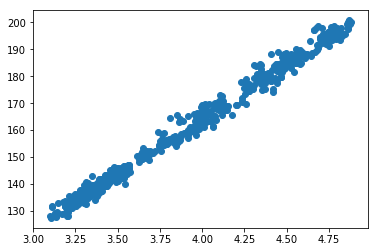

In [7]:
plt.scatter(linear_data['signal'], linear_data['spy_close_price'])
plt.show()

### After seeing the linear correlation, we can now model the data using Linear Regression.
### We then find the coefficient or slope of the line.
### The mean square error to see how well the line fits
$ MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i- \hat{Y_i})^2$
### Finally we find the R-Squared value to see how close the data fits the regression line

Coefficients: 
 [40.82405753]
Mean squared error: 4.54
R-squared = : 0.56


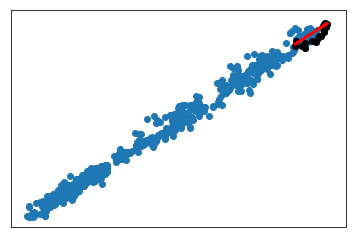

In [8]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training/testing sets
X_train = linear_data['signal'][:-20]
X_test = linear_data['signal'][-20:]

# Split the targets into training/testing sets
y_train = linear_data['spy_close_price'][:-20]
y_test = linear_data['spy_close_price'][-20:]

# Create linear regression object
regr = linear_model.LinearRegression()
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared = : %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(linear_data['signal'], linear_data['spy_close_price'])
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='red', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

After cleaning up the spy_close_price data, we can see the correlation between the date and price

In [9]:
df = x
df = df[df.loc[:,'spy_close_price'] < 300]
df = df[df.loc[:,'spy_close_price'] > 0]

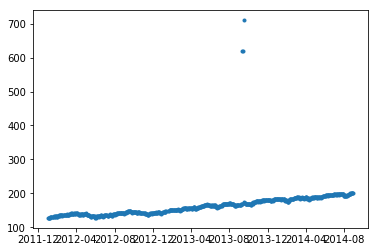

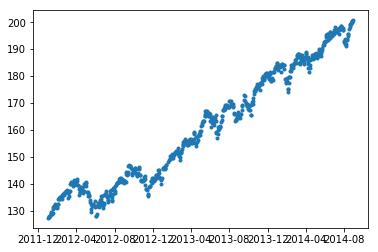

In [10]:
plt.plot(x.index.tolist(), x['spy_close_price'], '.')
plt.show()

plt.plot(df.index.tolist(), df['spy_close_price'], '.')
plt.show()

### We now create the time series data

In [11]:
ts = df.drop(columns=['signal'])
ts.head()

,spy_close_price
date,
2012-01-03,127.495
2012-01-04,127.700
2012-01-05,128.040
2012-01-06,127.710
2012-01-09,128.020


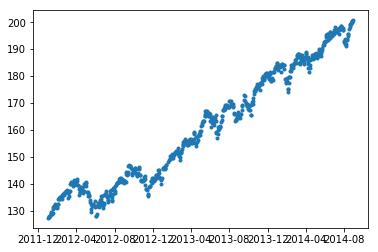

In [12]:
plt.plot(ts, '.')
plt.show()

## SOME COMPUTATION

In [50]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

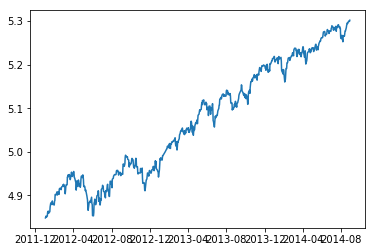

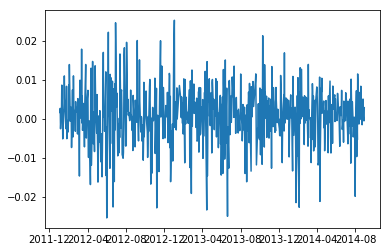

In [51]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  """
/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()
  


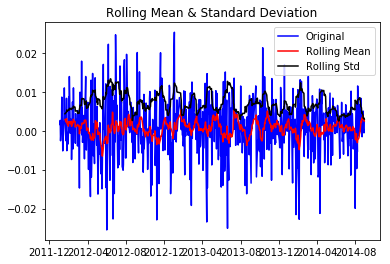

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

In [52]:
test_stationarity(ts_log_diff)

## FORCASTING TIME SERIES

We use the autocorrelation function to find a pattern between the prices seperated by certain time periods.
The partial autocorrelation function is used to control the other lag values that the acf misses.

In [53]:
from statsmodels.tsa.stattools import acf, pacf

ts_log_diff.dropna(inplace=True)

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

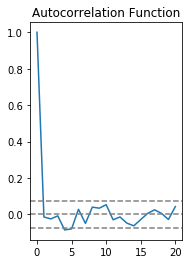

In [54]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

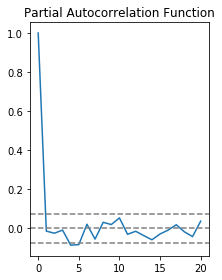

In [55]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [56]:
ts_log_diff.head()

,spy_close_price
date,
2012-01-04,0.001607
2012-01-05,0.002659
2012-01-06,-0.002581
2012-01-09,0.002424
2012-01-10,0.008633


Using the autoregressive integrated moving average (ARIMA) to better understand the data to predict future points.

In [57]:
from statsmodels.tsa.arima_model import ARIMA

/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


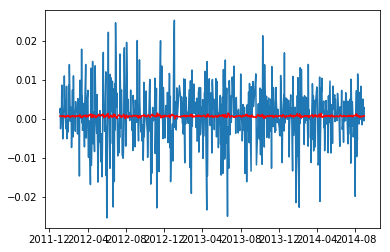

In [58]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.show()

/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


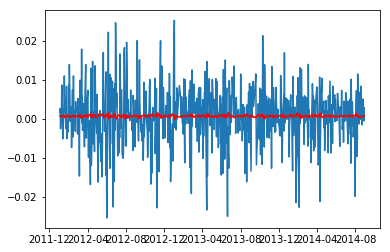

In [59]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.show()

/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/envs/py3k/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdt

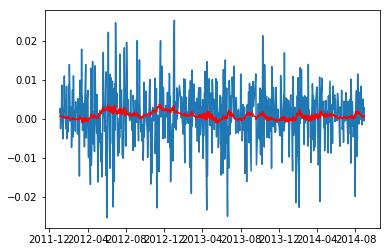

In [60]:

model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()

In [61]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2012-01-04    0.000680
2012-01-05    0.000655
2012-01-06    0.000617
2012-01-09    0.000726
2012-01-10    0.000605
dtype: float64


In [62]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

date
2012-01-04    0.000680
2012-01-05    0.001335
2012-01-06    0.001953
2012-01-09    0.002678
2012-01-10    0.003283
dtype: float64


In [63]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0][0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

date
2012-01-03    4.848077
2012-01-04    4.848757
2012-01-05    4.849412
2012-01-06    4.850030
2012-01-09    4.850755
dtype: float64

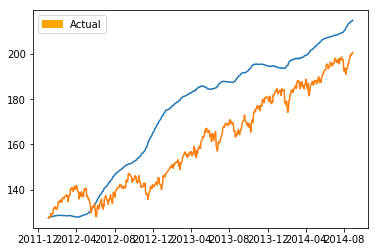

In [64]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(predictions_ARIMA)
#plt.show()
plt.plot(ts)
blue_patch = mpatches.Patch(color='blue', label='Prediction')
plt.legend(handles=[blue_patch])
orange_patch = mpatches.Patch(color='orange', label='Actual')
plt.legend(handles=[orange_patch])
plt.show()

# RNN

In [65]:
ts = ts.sort_index(axis=1, ascending=True)

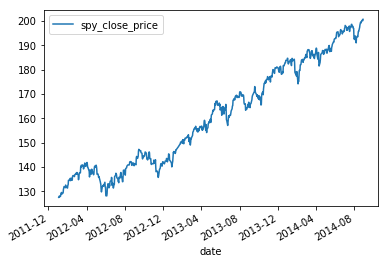

In [66]:
data = ts[['spy_close_price']]
data.plot(y='spy_close_price')
plt.show()

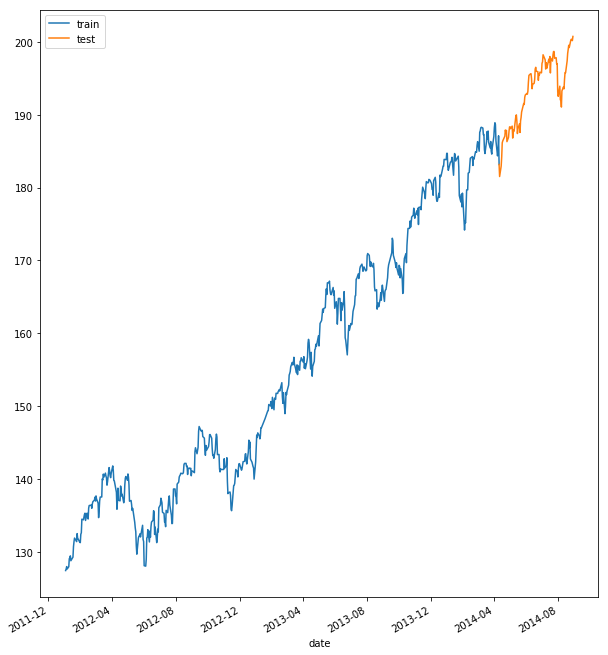

In [67]:
split_date = pd.Timestamp('04-10-2014')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [73]:
train_sc_df = pd.DataFrame(train, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [74]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (0 x 1)
Test size: (0 x 1)


## Setup baseline model of SVM Regressor


In [70]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [71]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

In [ ]:
from  sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print(r2_test)

In [ ]:
from  keras.models  import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

In [ ]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

In [ ]:
y_pred = model.predict(y_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))
plt.show()

In [ ]:
K.clear_session()
model = Sequential()
model.add(Dense(2, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

In [ ]:
y_pred = model.predict(y_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))
plt.show()